In [1]:
import sys
sys.path.append('../core/')
sys.path.append('../networks/')
from ssl_fc import SSL_Encoder1, SSL_Encoder2, SSL_Decoder
from m2 import SSL_M2
from misc_ops import *

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
from tensorflow.python.framework import dtypes
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
from dataset import DataSet
mnist = read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [17]:
def split_data(dataset, num_labeled):
    """
    Split dataset into two datasets
    """
    n = dataset.num_examples
    x, y = dataset.next_batch(n)
    x1 = x[xrange(num_labeled),:]
    y1 = y[xrange(num_labeled),:]
    x2 = x[xrange(num_labeled, n),:]
    y2 = y[xrange(num_labeled, n),:]
    d1 = DataSet(x1, y1, dtype=dtypes.float32, reshape=False)
    d2 = DataSet(x2, y2, dtype=dtypes.float32, reshape=False)
    return d1, d2

In [4]:
# Split dataset into labeled and unlabeled
num_labeled = 20000
labeled, unlabeled = split_data(mnist.train, num_labeled)
_, y = labeled.next_batch(num_labeled)
print np.sum(y, axis=0)

[ 1993.  2286.  1962.  2099.  1910.  1801.  1961.  2047.  1926.  2015.]


In [5]:
tf.reset_default_graph()

In [6]:
# Train
sess = tf.InteractiveSession()
build_encoder1 = SSL_Encoder1(500)
build_encoder2 = SSL_Encoder2(500)
build_decoder = SSL_Decoder(500)

# as the number of labeled examples decreases, need alpha to decrease as well?
model = SSL_M2(sess, build_encoder1, build_encoder2, build_decoder, labeled, unlabeled,
            batch_size = 100, z_dim = 50, x_dim = 784, y_dim=10, alpha=55000./10,
           learning_rate = 1e-3, num_epochs = 10, load=False, lr_decay=0.95, lr_decay_freq=1000,
          checkpoint_name='test'
)

In [12]:
model.train()

Epoch 11 loss: 1025.85247408
Epoch 12 loss: 959.686636309
Epoch 13 loss: 924.422184492
Epoch 14 loss: 895.734459882
Epoch 15 loss: 888.341705126
Epoch 16 loss: 865.385371791
Epoch 17 loss: 839.912156895
Epoch 18 loss: 822.59203949
Epoch 19 loss: 818.199503043
Epoch 20 loss: 851.888371124


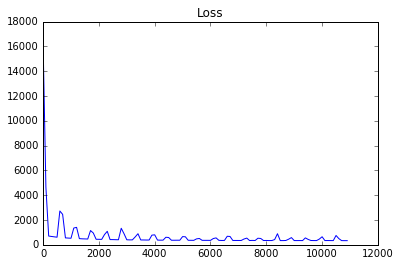

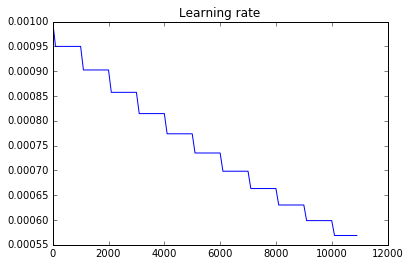

In [13]:
log = model.log
log = np.array(log).T
plt.plot(log[0,], log[1,])
plt.title('Loss')
plt.show()
plt.plot(log[0,], log[2,])
plt.title('Learning rate')
plt.show()

In [7]:
#Load
sess = tf.InteractiveSession()
build_encoder1 = SSL_Encoder1(500)
build_encoder2 = SSL_Encoder2(500)
build_decoder = SSL_Decoder(500)

model = SSL_M2(sess, build_encoder1, build_encoder2, build_decoder, labeled, unlabeled,
            batch_size = 100, z_dim = 50, x_dim = 784, y_dim=10, alpha=55000./10,
           learning_rate = 1e-3, num_epochs = 20, load=True,
        load_file = "checkpoints/test"
              )

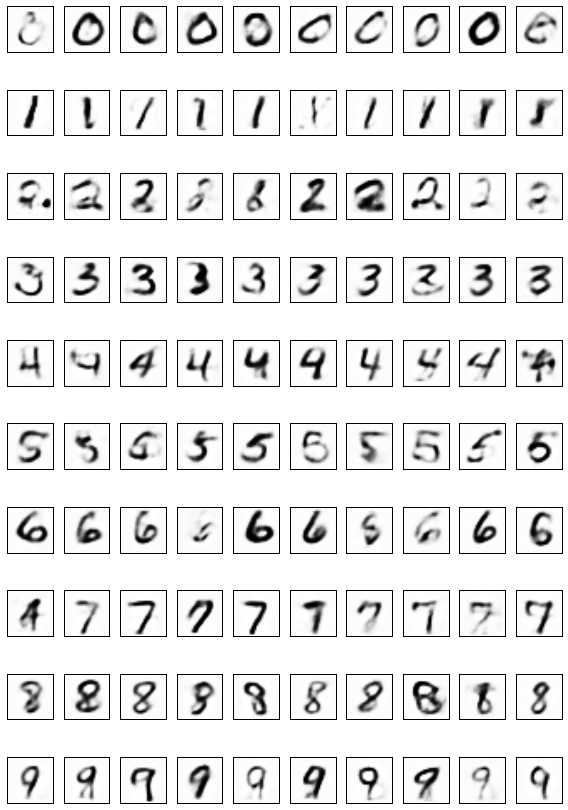

In [14]:
#images, info = mnist.test.next_batch(100)
num_examples = 10
batch_size = 100

labels = np.repeat(np.identity(10), num_examples, axis=0)
generated_images = model.generate(num=batch_size, labels=labels)


plt.figure(figsize=(8,12))
for i in xrange(10):
    for j in xrange(num_examples):
        plt.subplot(10, num_examples, 10*i+j+1)
        plt.imshow(generated_images[10*i+j,].reshape(28, 28), cmap='gray_r')
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
#plt.savefig('images/SSL_generate_600')
plt.show()

In [15]:
# Classify validation images
batch_size = 100
num_val = mnist.validation.num_examples
tot = 0
for t in xrange(num_val / batch_size):
    x_val, y_val = mnist.validation.next_batch(batch_size)
    y_pred = model.classify(x_val)
    y_val = np.argmax(y_val, axis=1)
    tot += np.sum(y_pred != y_val)
print "Error: {}".format(float(tot)/num_val)
#with open("SSL_errors/SSL_err_600.txt", "w") as text_file:
    #text_file.write("Validation error: {}\n".format(float(tot)/num_val))

Error: 0.0204


In [16]:
# Classify test images
batch_size = 100
num_test = mnist.test.num_examples
tot = 0
for t in xrange(num_test / batch_size):
    x_test, y_test = mnist.test.next_batch(batch_size)
    y_pred = model.classify(x_test)
    y_test = np.argmax(y_test, axis=1)
    tot += np.sum(y_pred != y_test)
print "Error: {}".format(float(tot)/num_test)
#with open("SSL_errors/SSL_err_600.txt", "a") as text_file:
    #text_file.write("Test error: {}".format(float(tot)/num_test))

Error: 0.0228


In [29]:
sess.close()

In [ ]:
# as the number of labeled examples decreases, need alpha to decrease as well